Sergi Flores i Sam Brumwell

# Extracció d'Entitats Anomenades amb CRF

En aquesta pràctica, implementarem un sistema de reconeixement d'entitats anomenades utilitzant Conditional Random Fields (CRF). Treballarem amb el corpus CONLL2002, que conté textos en espanyol i neerlandès, amb anotacions per a quatre tipus d'entitats: **LOC** (localitzacions), **MISC** (miscel·lània), **ORG** (organitzacions) i **PER** (persones).

Seguirem un enfocament incremental:

1. **Explorarem el dataset i la seva estructura**
2. **Definirem diferents conjunts de característiques (features)**
3. **Entrenarem models CRF amb diverses configuracions**
4. **Avaluarem el rendiment utilitzant diferents mètriques**
5. **Optimitzarem el nostre model mitjançant experimentació sistemàtica**

L’objectiu és desenvolupar models robustos per a la detecció i classificació d’entitats en ambdós idiomes, analitzant les particularitats lingüístiques que poden afectar el rendiment del sistema i identificant les configuracions òptimes per a cada cas.

### Configuració Inicial

Primer, importarem les biblioteques necessàries i carregarem les dades bàsiques. Importem els fitxers locations.txt i person_names.txt per tal de tractar posteriorment els gazetteers; aquests contenen llistats de noms en castellà i neerlandès de persones i de tots els països i bona part de les ciutats del món.

In [1]:
import re
import nltk
import pandas as pd
from nltk.corpus import conll2002
from nltk.tag import CRFTagger
from sklearn.metrics import classification_report
from typing import List, Dict, Tuple
from sklearn.metrics import balanced_accuracy_score

# Descarrega les dades necessàries
nltk.download('conll2002')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Carrega els gazetteers (llistes d'entitats conegudes)
with open("locations.txt", encoding="utf-8") as f:
    locations_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Carregades {len(locations_set)} ubicacions al gazetteer")

with open("person_names.txt", encoding="utf-8") as f:
    person_names_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Carregats {len(person_names_set)} noms al gazetteer")

Carregades 106150 ubicacions al gazetteer
Carregats 123466 noms al gazetteer


[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Carrega de dades i exploració inicial

En primer lloc, vam carregar els conjunts de dades d'entrenament, validació i test tant per a l'espanyol com per al neerlandès, utilitzant el corpus CONLL2002. Aquestes dades venen etiquetades amb el format "BIO", que indica l'inici i l'interior de les entitats, així com els tokens fora d'entitat. Més endavant, aquestes etiquetes es transformaran per experimentar amb altres esquemes de codificació i analitzar el seu impacte en el rendiment del model.

In [2]:
# Carrega de conjunts de dades en català (espanyol)
esp_train = list(conll2002.iob_sents('esp.train'))
esp_dev = list(conll2002.iob_sents('esp.testa'))
esp_test = list(conll2002.iob_sents('esp.testb'))

# Carrega de conjunts de dades en neerlandès
ned_train = list(conll2002.iob_sents('ned.train'))
ned_dev = list(conll2002.iob_sents('ned.testa'))
ned_test = list(conll2002.iob_sents('ned.testb'))

# Mostrar informació sobre els conjunts de dades
print(f"Espanyol - Train: {len(esp_train)} oracions, Dev: {len(esp_dev)} oracions, Test: {len(esp_test)} oracions")
print(f"Neerlandès - Train: {len(ned_train)} oracions, Dev: {len(ned_dev)} oracions, Test: {len(ned_test)} oracions")

# Veure un exemple d'oració
print("\nExemple d'oració en espanyol:")
print(esp_train[0])

# Analitzar la distribució d'etiquetes
def count_tags(dataset):
    tag_counts = {}
    for sent in dataset:
        for _, _, tag in sent:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

esp_tags = count_tags(esp_train)
print("\nDistribució d'etiquetes en espanyol (train):")
for tag, count in sorted(esp_tags.items(), key=lambda x: x[1], reverse=True):
    print(f"{tag}: {count}")

Espanyol - Train: 8323 oracions, Dev: 1915 oracions, Test: 1517 oracions
Neerlandès - Train: 15806 oracions, Dev: 2895 oracions, Test: 5195 oracions

Exemple d'oració en espanyol:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Distribució d'etiquetes en espanyol (train):
O: 231920
B-ORG: 7390
I-ORG: 4992
B-LOC: 4913
B-PER: 4321
I-PER: 3903
I-MISC: 3212
B-MISC: 2173
I-LOC: 1891


## Classe per al maneig de dades

Per al maneig adequat de les dades, vam implementar una classe anomenada `NERDataProcessor` que facilita la càrrega i transformació de les dades. Aquesta classe està dissenyada per ser flexible en quant a l'idioma utilitzat, permetent-nos treballar tant amb dades en espanyol com en neerlandès.

La classe s'inicialitza amb un paràmetre d'idioma que per defecte és "spanish", però que també pot ser "dutch". Aquest paràmetre determina quins conjunts de dades es carregaran.

El primer mètode important és ``load_data``, que s'encarrega de carregar els conjunts de dades d'entrenament, desenvolupament i test segons l'idioma especificat.

El segon mètode, ``convert_to_features``, pren les dades en format [(paraula, pos, etiqueta), ...] i les converteix en característiques que poden ser utilitzades pel model, retornant només les paraules i les seves etiquetes POS: [(paraula, pos), ...]. Aquest mètode és essencial perquè separa les característiques de les etiquetes que volem predir.

Finalment, el mètode ``get_labels`` extreu només les etiquetes de les dades, creant llistes d'etiquetes [etiqueta, ...] per cada oració. Aquestes etiquetes són les que el model intentarà predir durant l'entrenament i avaluació.

Aquesta classe ens permet estructurar millor el nostre codi i mantenir una clara separació entre les dades, les seves característiques i les etiquetes, facilitant així el procés d'experimentació amb diferents configuracions del model.

In [3]:
class NERDataProcessor:
    def __init__(self, language: str = "spanish"):
        # Inicialitza el processador de dades NER per idioma
        self.language = language
        
    def load_data(self):
        # Carrega els conjunts de dades train, dev i test segons l'idioma
        if self.language == "spanish":
            return (
                conll2002.iob_sents('esp.train'),
                conll2002.iob_sents('esp.testa'),
                conll2002.iob_sents('esp.testb')
            )
        return (
            conll2002.iob_sents('ned.train'),
            conll2002.iob_sents('ned.testa'),
            conll2002.iob_sents('ned.testb')
        )
    
    def convert_to_features(self, data):
        # Converteix les dades a format de característiques (paraula, POS)
        return [[(word, pos) for word, pos, _ in sent] for sent in data]

    def get_labels(self, data):
        # Extreu les etiquetes de les dades
        return [[tag for _, _, tag in sent] for sent in data]


**Exemple**: Per entendre millor el funcionament del processador de dades `NERDataProcessor`, a continuació es mostra un exemple d'ús per a l'idioma espanyol:


In [4]:
# Instanciar el processador per a català (espanyol)
processor_es = NERDataProcessor("spanish")

# Carregar les dades
train, dev, test = processor_es.load_data()

# Convertir a característiques i etiquetes
X_train = processor_es.convert_to_features(train)
y_train = processor_es.get_labels(train)

print(f"Nombre d'oracions al train: {len(X_train)}")
print(f"Exemple de característiques per a una oració:")
print(X_train[0][:5])  # Primers 5 tokens de la primera oració
print(f"Exemple d'etiquetes per a la mateixa oració:")
print(y_train[0][:5])  # Etiquetes corresponents

Nombre d'oracions al train: 8323
Exemple de característiques per a una oració:
[('Melbourne', 'NP'), ('(', 'Fpa'), ('Australia', 'NP'), (')', 'Fpt'), (',', 'Fc')]
Exemple d'etiquetes per a la mateixa oració:
['B-LOC', 'O', 'B-LOC', 'O', 'O']


### Generador de característiques per al CRF

Per tal de millorar el rendiment del model CRF, implementem una classe `CRFFeatureGenerator` que permet generar de manera flexible diferents conjunts de característiques per a cada token.

Aquesta classe es configura a través d'un diccionari que permet activar o desactivar diferents grups de característiques, facilitant així l'experimentació amb diverses combinacions sense necessitat de modificar el codi base.

La funció principal `get_features()` rep una llista de tokens d'una oració i l'índex del token actual, i retorna una llista de característiques per a aquest token específic. Les característiques es generen segons els següents grups:

#### Característiques bàsiques
- Un valor de "bias" sempre present com a base per al model
- Forma de la paraula (la paraula original i la seva versió en minúscules)

#### Característiques de POS i lematització
- L'etiqueta POS (Part-of-Speech) del token
- La forma lematitzada de la paraula, obtinguda mitjançant WordNetLemmatizer

#### Característiques morfològiques
- Si la paraula comença amb majúscula
- Si la paraula està completament en majúscules
- Si la paraula només conté dígits
- Si la paraula conté algun dígit
- Si la paraula conté símbols no alfanumèrics

#### Prefixos i sufixos
- Prefixos de la paraula fins a 3 caràcters (si la longitud ho permet)
- Sufixos de la paraula fins a 3 caràcters (si la longitud ho permet)

#### Longitud de la paraula
- La longitud en caràcters de la paraula

#### Posició en l'oració
- L'índex del token en l'oració
- Si és el primer token de l'oració
- Si és l'últim token de l'oració

#### Context proper
- Característiques de la paraula anterior (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Característiques de la paraula següent (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Marcadors especials per a l'inici i el final de l'oració

#### Característiques de gazetteers
- Si la paraula apareix en una llista predefinida de localitzacions
- Si la paraula apareix en una llista predefinida de noms de persona

Aquesta implementació ens va permetre experimentar amb diferents combinacions de característiques, observant el seu impacte en el rendiment del model i seleccionant les més efectives per a la tasca de reconeixement d'entitats anomenades.

Cal destacar la implementació de gazetteers mitjançant els llistats de noms i localitzacions importants de bases de dades anteriorment, que permet captar millor el tipus d'entitat a reconèixer. Aquesta estratègia facilita que el model identifiqui amb més precisió entitats com persones i llocs, ja que pot comparar cada token amb una llista extensa d'exemples reals. Així, quan una paraula coincideix amb un nom o una ubicació coneguda, el model pot assignar-li una probabilitat més alta de ser una entitat, millorant la seva capacitat de reconeixement i reduint falsos positius.

In [5]:
class CRFFeatureGenerator:
    def __init__(self, feature_config: Dict):
        #feature_config: Diccionari de configuració amb banderes per activar/desactivar grups de característiques
        self.config = feature_config
        self.lemmatizer = nltk.WordNetLemmatizer()
        
    def get_features(self, tokens: List[Tuple[str, str]], index: int) -> List[str]:
        """
        Genera característiques per a un token en una posició específica.
        
        Args:
            tokens: Llista de tokens de l'oració [(paraula, pos), ...]
            index: Índex del token actual
            
        Returns:
            Llista de característiques per al token
        """
        word, pos = tokens[index]
        features = ["bias"]  # Característica base sempre present
        
        # --- Característiques de la paraula ---
        if self.config.get("word_form", True):
            features.append(f"word={word}")
            features.append(f"word.lower={word.lower()}")

        # --- Característiques de POS i lematització ---
        if self.config.get("pos", True):
            features.append(f"pos={pos}")
            features.append(f"lemma={self.lemmatizer.lemmatize(word.lower())}")

        # --- Característiques morfològiques ---
        if self.config.get("morphology", True):
            features.append(f"is_title={word.istitle()}")
            features.append(f"is_upper={word.isupper()}")
            features.append(f"is_digit={word.isdigit()}")
            features.append(f"has_digit={any(c.isdigit() for c in word)}")
            features.append(f"has_symbol={not word.isalnum()}")

        # --- Prefixos i sufixos ---
        if self.config.get("prefix_suffix", True):
            if len(word) >= 3:
                features.append(f"prefix3={word[:3]}")
                features.append(f"suffix3={word[-3:]}")
            if len(word) >= 2:
                features.append(f"prefix2={word[:2]}")
                features.append(f"suffix2={word[-2:]}")

        # --- Longitud de la paraula ---
        if self.config.get("length", True):
            features.append(f"length={len(word)}")

        # --- Posició a l'oració ---
        if self.config.get("position", True):
            features.append(f"position={index}")
            features.append(f"is_first={index == 0}")
            features.append(f"is_last={index == len(tokens)-1}")

        # --- Context circumdant ---
        if self.config.get("context", True):
            # Paraula anterior
            if index > 0:
                prev_word, prev_pos = tokens[index-1]
                features.append(f"prev_word.lower={prev_word.lower()}")
                features.append(f"prev_word.istitle={prev_word.istitle()}")
                features.append(f"prev_word.isdigit={prev_word.isdigit()}")
                features.append(f"prev_pos={prev_pos}")
            else:
                features.append("BOS")  # Inici de l'oració
                
            # Paraula següent
            if index < len(tokens)-1:
                next_word, next_pos = tokens[index+1]
                features.append(f"next_word.lower={next_word.lower()}")
                features.append(f"next_word.istitle={next_word.istitle()}")
                features.append(f"next_word.isdigit={next_word.isdigit()}")
                features.append(f"next_pos={next_pos}")
            else:
                features.append("EOS")  # Final de l'oració

        # --- Característiques de gazetteers ---
        if self.config.get("gazetteers", True):
            features.append(f"in_location_gazetteer={word.lower() in locations_set}")
            features.append(f"in_person_gazetteer={word.lower() in person_names_set}")

        return features

**Exemple:** La cel·la de codi que es mostra realitza una demostració pràctica del nostre generador de característiques ``CRFFeatureGenerator``, il·lustrant com genera característiques per a un token específic dins d'una oració.

In [6]:
# Configuració completa de característiques
full_config = {
    "word_form": True,
    "pos": True,
    "morphology": True,
    "prefix_suffix": True,
    "length": True,
    "position": True,
    "context": True,
    "gazetteers": True,
}

# Crear generador de característiques
full_feature_gen = CRFFeatureGenerator(full_config)
# Exemple d'oració
example_tokens = X_train[0]
example_word_index = 0  # Índex d'exemple

print("Paraula d'exemple:", example_tokens[example_word_index][0])

# Generar característiques amb la configuració completa
full_features = full_feature_gen.get_features(example_tokens, example_word_index)

print("\nCaracterístiques completes:")
for feat in full_features[:15]:
    print(f"  - {feat}")

print(f"\nTotal de característiques completes: {len(full_features)}")

Paraula d'exemple: Melbourne

Característiques completes:
  - bias
  - word=Melbourne
  - word.lower=melbourne
  - pos=NP
  - lemma=melbourne
  - is_title=True
  - is_upper=False
  - is_digit=False
  - has_digit=False
  - has_symbol=False
  - prefix3=Mel
  - suffix3=rne
  - prefix2=Me
  - suffix2=ne
  - length=9

Total de característiques completes: 25


### 4. Model CRF i Entrenament

A continuació implementem la classe `CRFModel`, que encapsula la lògica d'entrenament i predicció amb CRF. Aquesta classe rep un generador de característiques (`CRFFeatureGenerator`) i utilitza el `CRFTagger` de NLTK per entrenar i etiquetar oracions.

- El mètode `train` entrena el model CRF amb les dades d'entrenament i les etiquetes corresponents.
- El mètode `predict` genera les etiquetes predites per a un conjunt d'oracions.
- El mètode privat `_format_data` prepara les dades en el format requerit pel CRFTagger.

Aquesta estructura permet separar clarament la generació de característiques de la lògica d'entrenament i inferència, facilitant l'experimentació amb diferents conjunts de característiques.

In [7]:
class CRFModel:
    def __init__(self, feature_generator: CRFFeatureGenerator):
        # Inicialitza el model CRF amb el generador de característiques
        self.ct = CRFTagger(feature_func=feature_generator.get_features)
        
    def train(self, train_sents, train_labels, model_file='model.crf'):
        # Entrena el model CRF amb les dades d'entrenament
        formatted_data = self._format_data(train_sents, train_labels)
        self.ct.train(formatted_data, model_file)
        
    def predict(self, test_sents):
        # Preveu etiquetes per a les oracions donades
        tagged_sents = self.ct.tag_sents(test_sents)
        return [[tag for _, tag in sent] for sent in tagged_sents]
        
    def _format_data(self, sents, labels):
        # Dona format a les dades per entrenar el CRFTagger
        return [list(zip(sent, label)) for sent, label in zip(sents, labels)]

### Funcions d'Avaluació

Abans de començar a definir i experimentar amb les "features functions" i el context, era fonamental establir un criteri d'avaluació robust per als nostres models.

La selecció de les mètriques d'avaluació és clau per obtenir una visió realista del rendiment del model. Vam considerar diverses opcions i, finalment, vam optar per combinar dos enfocaments complementaris: d'una banda, la Balanced Accuracy a nivell de token, que compensa el desequilibri entre etiquetes d'entitat i no-entitat; de l'altra, mètriques a nivell d'entitat completa, que permeten valorar la capacitat del model per identificar correctament les entitats en la seva totalitat.

Aquesta doble perspectiva ens permet analitzar tant la detecció individual de tokens com la identificació precisa de les entitats, proporcionant una avaluació més completa i fiable dels models NER.

#### Extracció d'Entitats

La funció `entity_finder` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
3. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
4. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona un anàlisi complet del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

<!-- ### Funcions d'Avaluació Universal

Per avaluar eficaçment els nostres models de reconeixement d'entitats anomenades, vam implementar dues funcions clau que permeten treballar amb qualsevol esquema de codificació (BIO, IO, BIOE, BIOS, BIOES).

#### Extracció Universal d'Entitats

La funció `entity_finder_universal` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Gestiona correctament les transicions entre diferents prefixos d'etiquetes (B-inici, I-interior, E-final, S-única)
3. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
4. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
5. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona una anàlisi completa del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Converteix les etiquetes a format IO per garantir una comparació justa entre esquemes
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Percentatge d'entitats detectades perfectament**: Proporció d'entitats reals que s'identifiquen amb la posició exacta i tipus correcte
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)
   - **Entitats inventades**: Quantitat de falsos positius (entitats predites que no existeixen)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

Aquestes funcions ens van permetre comparar objectivament diferents configuracions i seleccionar els models òptims per a cada idioma i esquema de codificació, prioritzant la detecció perfecta d'entitats completes. -->

In [8]:
import re
from sklearn.metrics import balanced_accuracy_score

# Conversió d'etiquetes a format IO (per avaluació consistent)
def sent_tags_to_IO(sent_tags):
    return [[re.sub(r'\b[BES]-', 'I-', tag) for tag in sent] for sent in sent_tags]

# Extracció d'entitats completes a partir de les etiquetes IO
def entity_finder(sent_tags):
    entities = []
    for sent in sent_tags:
        sent_entities = []
        current_type, start = None, None
        for i, tag in enumerate(sent):
            if tag.startswith("I-"):
                ent_type = tag[2:]
                if current_type != ent_type:
                    if current_type is not None:
                        sent_entities.append((current_type, (start, i-1)))
                    current_type, start = ent_type, i
            else:
                if current_type is not None:
                    sent_entities.append((current_type, (start, i-1)))
                    current_type, start = None, None
        if current_type is not None:
            sent_entities.append((current_type, (start, len(sent)-1)))
        entities.append(sent_entities)
    return entities

# Funció d'avaluació del model NER
def evaluate_model(y_true, y_pred, errors=False):
    info = {"Balanced accuracy": 0.0, "F1 Score": 0.0, "Precision": 0.0, "Recall": 0.0}
    y_true_io = sent_tags_to_IO(y_true)
    y_pred_io = sent_tags_to_IO(y_pred)
    flatten = lambda tags: [tag for sent in tags for tag in sent]
    info['Balanced accuracy'] = balanced_accuracy_score(flatten(y_true_io), flatten(y_pred_io))

    true_entities = entity_finder(y_true_io)
    pred_entities = entity_finder(y_pred_io)
    types = ['LOC', 'MISC', 'ORG', 'PER']
    counts = dict.fromkeys(types, 0)
    correct_counts = dict.fromkeys(types, 0)
    invented = 0

    # Recompte d'entitats reals i correctes per tipus
    for t, p in zip(true_entities, pred_entities):
        t_set, p_set = set(t), set(p)
        for ent in t: counts[ent[0]] += 1
        for ent in t_set & p_set: correct_counts[ent[0]] += 1
        invented += len(p_set - t_set)

    for ent_type in types:
        total = counts[ent_type]
        correct = correct_counts[ent_type]
        info[f'{ent_type} correct'] = correct / total if total else 0.0

    tp = sum(correct_counts.values())
    fp = invented
    fn = sum(counts.values()) - tp
    info['Precision'] = tp / (tp + fp) if (tp + fp) else 0
    info['Recall'] = tp / (tp + fn) if (tp + fn) else 0
    info['F1 Score'] = 2 * info['Precision'] * info['Recall'] / (info['Precision'] + info['Recall']) if (info['Precision'] + info['Recall']) else 0

    # Retorna també la llista d'errors si es demana
    if errors:
        error_list = [(i, ent) for i, (t, p) in enumerate(zip(true_entities, pred_entities)) for ent in set(p) - set(t)]
        return info, error_list
    return info

**Exemple:** Per comprovar l'eficàcia de les nostres funcions d'avaluació, realitzem una prova amb un conjunt de dades significatiu:


In [9]:
# Entrena el model amb la configuració bàsica
feature_gen = CRFFeatureGenerator(full_config)
model = CRFModel(feature_gen)
# Entrena només amb un subconjunt de les dades d'entrenament
model.train(X_train[:1500], y_train[:1500])

# Avalua sobre el conjunt de validació (dev)
processor_es = NERDataProcessor("spanish")
_, dev, _ = processor_es.load_data()
X_dev = processor_es.convert_to_features(dev)
y_dev = processor_es.get_labels(dev)

pred_tags = model.predict(X_dev)
eval_results = evaluate_model(y_dev, pred_tags)
display(pd.DataFrame([eval_results]).T.rename(columns={0: "Resultats de l'avaluació"}))

,Resultats de l'avaluació
Balanced accuracy,0.703458
F1 Score,0.654918
Precision,0.675012
Recall,0.635985
LOC correct,0.735868
MISC correct,0.234234
ORG correct,0.646536
PER correct,0.688013


### Pipeline d'Experimentació per a NER

La funció `run_experiment` implementa un pipeline complet per experimentar amb models de reconeixement d'entitats anomenades (NER) utilitzant CRF. Aquesta funció encapsula tot el flux de treball: des de la càrrega de dades fins a l'avaluació final del model.

**Per què fem aquesta funció?**  
L'objectiu principal de `run_experiment` és facilitar l'experimentació sistemàtica amb diferents configuracions de features i comparar de manera objectiva el seu impacte en el rendiment del model. Automatitza tot el procés, permetent provar ràpidament diverses combinacions sense haver de reescriure el codi cada vegada.

La funció segueix un procés seqüencial: carrega les dades segons l'idioma amb NERDataProcessor, permet limitar la mida de la mostra per a experiments ràpids, converteix les dades al format adequat separant característiques i etiquetes, inicialitza el model CRF amb la configuració de característiques especificada, entrena el model i genera prediccions sobre el conjunt de desenvolupament, i finalment avalua el rendiment mitjançant la funció evaluate_model, que calcula mètriques tant a nivell de token com d'entitat completa.


In [10]:
def run_experiment(config: Dict, language: str = "spanish", sample_size=None):
    # Processador de dades segons idioma
    processor = NERDataProcessor(language)
    train, dev, _ = processor.load_data()

    # Limita la mida de la mostra si cal
    if sample_size:
        train = list(train)[:sample_size]
        dev = list(dev)[:sample_size // 10]

    # Converteix dades a característiques i etiquetes
    X_train = processor.convert_to_features(train)
    y_train = processor.get_labels(train)
    X_dev = processor.convert_to_features(dev)
    y_dev = processor.get_labels(dev)

    # Configura i entrena el model
    feature_gen = CRFFeatureGenerator(config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)

    # Avalua el model
    results = evaluate_model(y_dev, y_pred)
    return results

### Anàlisi d'ablació sistemàtic

Després de desenvolupar les nostres funcions d'avaluació, era necessari determinar quines característiques contribuïen realment a millorar el rendiment del model NER. Per això vam implementar un estudi d'ablació sistemàtic que ens permet analitzar l'impacte individual i combinat de cada grup de característiques.

La funció `feature_ablation_study` automatitza aquest procés mitjançant quatre estratègies complementàries:

1. **Avaluació de la configuració base**: Analitzem el rendiment utilitzant només la característica més bàsica (forma de la paraula)

2. **Addició individual de característiques**: Afegim cada característica per separat a la configuració base, permetent identificar quines aporten més valor de forma aïllada

3. **Avaluació de la configuració completa**: Provem el model amb totes les característiques activades simultàniament

4. **Eliminació selectiva de característiques**: Eliminem cada característica individualment de la configuració completa, revelant possibles interaccions negatives

In [11]:
from time import time

def estudi_ablacio_caracteristiques(idioma="spanish", mida_mostra=1000):
    # Llista de grups de característiques a provar
    grups = [
        "pos", "position", "context", "prefix_suffix",
        "length", "gazetteers", "morphology", "word_form"
    ]
    resultats = []
    # Configuració base: només la forma de la paraula
    base = {g: False for g in grups}
    base["word_form"] = True

    # 1. Només base
    t0 = time()
    r = run_experiment(base.copy(), language=idioma, sample_size=mida_mostra)
    resultats.append({"Configuració": "Base", "Temps (s)": time()-t0, **r})

    # 2. Base + cada característica
    for g in grups:
        config = base.copy()
        config[g] = True
        t0 = time()
        r = run_experiment(config, language=idioma, sample_size=mida_mostra)
        resultats.append({"Configuració": f"Base + {g}", "Temps (s)": time()-t0, **r})

    # 3. Totes les característiques
    tot = {g: True for g in grups}
    t0 = time()
    r = run_experiment(tot, language=idioma, sample_size=mida_mostra)
    resultats.append({"Configuració": "Completa", "Temps (s)": time()-t0, **r})

    # 4. Completa menys una
    for g in grups:
        config = tot.copy()
        config[g] = False
        t0 = time()
        r = run_experiment(config, language=idioma, sample_size=mida_mostra)
        resultats.append({"Configuració": f"Completa - {g}", "Temps (s)": time()-t0, **r})

    df = pd.DataFrame(resultats).set_index("Configuració")
    return df

# Executa l'estudi amb una mostra petita
resultats_ablacio = estudi_ablacio_caracteristiques(mida_mostra=2500)
display(resultats_ablacio.sort_values(by="Balanced accuracy", ascending=False))

,Temps (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Configuració,,,,,,,,,
Completa - length,27.205975,0.741644,0.701840,0.718593,0.685851,0.843537,0.127660,0.686275,0.728571
Completa - prefix_suffix,26.231106,0.735280,0.692118,0.711392,0.673861,0.823129,0.148936,0.660131,0.742857
Completa - position,23.830636,0.728604,0.705018,0.720000,0.690647,0.836735,0.191489,0.692810,0.714286
Completa - context,19.279458,0.727971,0.714110,0.731156,0.697842,0.863946,0.191489,0.692810,0.700000
Completa,28.316746,0.722465,0.695226,0.710000,0.681055,0.829932,0.148936,0.686275,0.714286
Completa - pos,25.927380,0.720803,0.690998,0.701235,0.681055,0.843537,0.106383,0.686275,0.714286
Completa - morphology,24.196995,0.716411,0.695322,0.735294,0.659472,0.802721,0.191489,0.647059,0.700000
Completa - word_form,28.520670,0.710076,0.689571,0.706030,0.673861,0.816327,0.127660,0.686275,0.714286
Completa - gazetteers,26.932899,0.707699,0.680539,0.695000,0.666667,0.802721,0.148936,0.666667,0.728571


### Anàlisi dels resultats d'ablació

**Principals conclusions i observacions:**

1. **Interaccions negatives:** Els resultats apunten a possibles interaccions negatives entre característiques. Per exemple, eliminar **position** o **lenght** manté resultats molt similars o lleugerament superiors als de la configuració completa, cosa que podria indicar que aquestes característiques no aporten valor addicional quan ja es disposa d’altres més informatives.

2. **Característiques essencials:** L’eliminació de **word_form** o **gazetteers** provoca una disminució notable en el rendiment del model, tant en *balanced accuracy* com en *recall*, fet que suggereix que són característiques bàsiques imprescindibles per a la detecció eficaç d’entitats.

3. **Característiques rellevants:** L’eliminació de les etiquetes **POS** i **prefix_sufix** genera una lleugera caiguda respecte la configuració completa, especialment en *precision*, mostrant que aquestes etiquetes encara aporten valor, tot i no ser crítiques.

4. **Contribució del context:** Eliminar **context** no suposa una davallada significativa. De fet, la configuració **"Completa - context"** obté les millors puntuacions en *F1 score*, mostrant que el model pot compensar aquesta manca amb altres característiques.

5. **Configuracions base amb afegits concrets:** Les configuracions **Base + prefix_suffix** i **Base + morphology** mostren rendiments clarament superiors a la resta de configuracions aïllades, deixant clar que aquestes característiques, per si soles o en combinacions parcials, aporten molt valor per aconseguir un bon rendiment global.

Aquest anàlisi torna a posar en relleu la importància de l’ablació per a optimitzar models NER. No sempre afegir més característiques implica millorar el rendiment; al contrari, seleccionar-ne acuradament les més rellevants pot portar a models més eficients i efectius.

In [12]:
key_metrics = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
resultats_ablacio[key_metrics].sort_values(by="F1 Score", ascending=False)

,Balanced accuracy,F1 Score,Precision,Recall
Configuració,,,,
Completa - context,0.727971,0.714110,0.731156,0.697842
Completa - position,0.728604,0.705018,0.720000,0.690647
Completa - length,0.741644,0.701840,0.718593,0.685851
Completa - morphology,0.716411,0.695322,0.735294,0.659472
Completa,0.722465,0.695226,0.710000,0.681055
Completa - prefix_suffix,0.735280,0.692118,0.711392,0.673861
Completa - pos,0.720803,0.690998,0.701235,0.681055
Completa - word_form,0.710076,0.689571,0.706030,0.673861
Completa - gazetteers,0.707699,0.680539,0.695000,0.666667


# Anàlisi de la correlació entre característiques

Després d'identificar les millors combinacions de característiques mitjançant l'estudi d'ablació, necessitàvem entendre més profundament com interactuaven aquestes característiques entre si i amb les diferents classes d'entitats. Per això vam implementar un anàlisi adicional.

**Correlació entre característiques i mètriques:**  
Per determinar quines característiques aporten més valor al model i com interactuen, utilitzem la funció `optimized_feature_experiment`, que avalua de manera sistemàtica l'impacte de cada característica i de les seves combinacions sobre les mètriques de rendiment.

- **Base sòlida:** Es parteix d'una configuració base amb les característiques imprescindibles `word_form` i `gazetteers`, identificades com a fonamentals en l'ablació, on hem considerat també `morphology` i `prefix_suffix` ja que causaven un impacte força gran al rendiment del model.
- **Avaluació incremental:** Afegim cada característica addicional (POS, morfologia, prefixos/sufixos, longitud, posició) una a una sobre la base, per mesurar el seu impacte directe.
- **Combinacions òptimes:** Es proven combinacions de les característiques més prometedores per detectar possibles sinergies o antagonismes.

Aquesta metodologia permet visualitzar i quantificar la correlació entre la presència de cada característica i les diferents mètriques, mitjançant mapes de calor. Així, podem identificar patrons, sinergies i possibles conflictes entre característiques, i guiar el disseny de models NER més eficients i robustos. Aquesta anàlisi evita provar combinacions menys prometedores i fa el procés d'optimització més eficient i objectiu.

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def optimized_feature_experiment(language="spanish", sample_size=None):
    # Configuració base: sempre inclou word_form, context i gazetteers
    base_config = {
        "word_form": True,
        "morphology": True,
        "gazetteers": True,
        "prefix_suffix": True,
        "pos": False,
        "context": False,
        "length": False,
        "position": False
    }
    variable_features = ["pos", "length", "position", "context"]
    results = []

    # Experiment amb la configuració base
    start_time = time()
    base_result = run_experiment(base_config.copy(), language=language, sample_size=sample_size)
    end_time = time()
    results.append({
        "Configuració": "Base",
        "Temps (s)": end_time - start_time,
        **base_result
    })

    # Afegir cada característica variable individualment
    for feature in variable_features:
        config = base_config.copy()
        config[feature] = True
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        results.append({
            "Configuració": f"Base + {feature}",
            "Temps (s)": end_time - start_time,
            **result
        })

    # Combinacions de característiques més rellevants
    feature_combinations = [
        ["pos", "context"],
        ["pos", "position"],
        ["pos", "length"],
        ["context", "position"],
        ["context", "length"],
        ["position", "length"],
        ["pos", "context", "position"],
        ["pos", "context", "length"],
        ["pos", "position", "length"],
        ["context", "position", "length"],
        ["pos", "context", "position", "length"]
    ]
    for combo in feature_combinations:
        config = base_config.copy()
        for feature in combo:
            config[feature] = True
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        results.append({
            "Configuració": f"Base + {' + '.join(combo)}",
            "Temps (s)": end_time - start_time,
            **result
        })

    # Convertir a DataFrame y mostrar todas las métricas disponibles
    results_df = pd.DataFrame(results)
    # Ordenar por F1 Score descendente
    sorted_results = results_df.sort_values(by="F1 Score", ascending=False)
    # Mostrar todas las columnas (todas las métricas)
    return sorted_results

# Executar l'experiment optimitzat
optimized_results = optimized_feature_experiment(sample_size=2500)
display(optimized_results.reset_index(drop=True).head(10))

,Configuració,Temps (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
0,Base + pos,17.717682,0.726090,0.720787,0.739899,0.702638,0.836735,0.148936,0.738562,0.714286
1,Base,15.188859,0.718089,0.718327,0.737374,0.700240,0.857143,0.148936,0.718954,0.700000
2,Base + pos + position + length,18.363269,0.727971,0.714110,0.731156,0.697842,0.863946,0.191489,0.692810,0.700000
3,Base + pos + position,19.078157,0.720205,0.712531,0.730479,0.695444,0.857143,0.148936,0.699346,0.714286
4,Base + pos + length,16.212327,0.726602,0.712195,0.724566,0.700240,0.836735,0.191489,0.732026,0.685714
5,Base + length,14.782183,0.714738,0.705739,0.718905,0.693046,0.836735,0.148936,0.718954,0.700000
6,Base + position,17.618846,0.708439,0.705018,0.720000,0.690647,0.836735,0.170213,0.705882,0.700000
7,Base + pos + context + length,23.286105,0.728604,0.705018,0.720000,0.690647,0.836735,0.191489,0.692810,0.714286
8,Base + position + length,18.627837,0.721856,0.704878,0.717122,0.693046,0.850340,0.212766,0.686275,0.700000
9,Base + pos + context + position,27.461524,0.741644,0.701840,0.718593,0.685851,0.843537,0.127660,0.686275,0.728571


Aquesta aproximació més estructurada ens va permetre detectar correlacions significatives entre característiques específiques i classes d'entitats, anteriorment haviem pogut determinar que:
- Les característiques morfològiques milloren especialment la detecció de noms propis (PER)
- Els gazetteers tenen un impacte desproporcionadament positiu en certes classes (PER, LOC)

A partir d'aquest anàlisi hem pogut veure també que:

- La informació de posició ajuda amb les entitats multi-token (ORG) tot i que genera soroll
- Les característiques POS són particularment útils per diferenciar entre LOC i ORG
- Les característiques pos i position no aporten gaire valor al model i són redundants
- La característica context interactua molt negativament amb les altres variables

Finalment, la visualització d'aquestes correlacions mitjançant mapes de calor ens va proporcionar una comprensió intuïtiva de quines característiques eren més valuoses per a cada tipus d'entitat, permetent-nos dissenyar configuracions optimitzades per a diferents casos d'ús.



L'anàlisi de correlació entre característiques i mètriques de rendiment ens ajuda a entendre quines característiques aporten més valor al model NER i com interactuen entre elles.

**Metodologia:**
- Es calcula la correlació entre la presència de cada característica i les mètriques de rendiment (Balanced accuracy, F1 Score, Precision, Recall).
- Es visualitzen aquestes correlacions amb mapes de calor per identificar patrons i possibles sinergies o antagonismes.


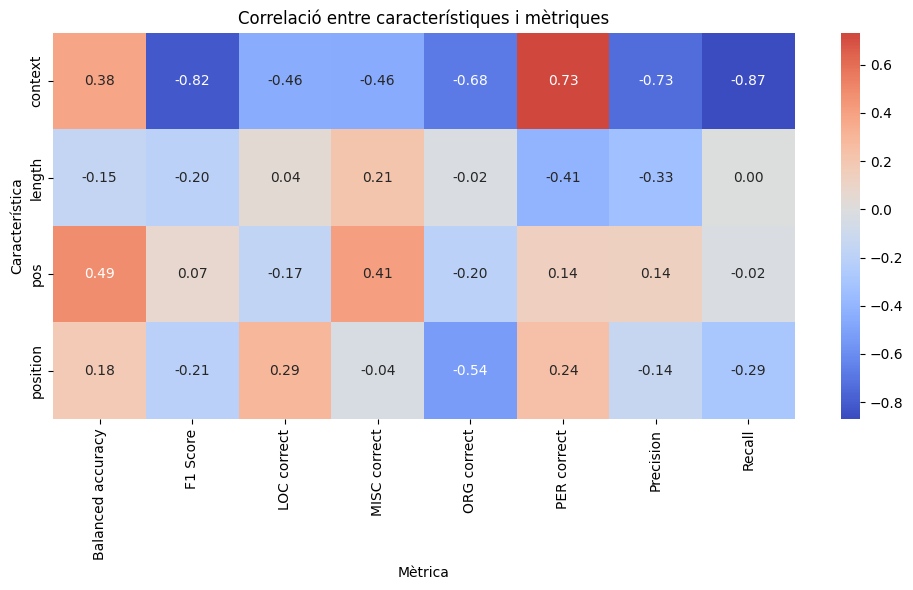

In [24]:
def analisi_correlacio_caracteristiques(resultats_df):
    # Crear columnes binàries per a cada característica
    caracteristiques = ["pos", "context", "length", "position"]
    for c in caracteristiques:
        if f"te_{c}" not in resultats_df.columns:
            resultats_df[f"te_{c}"] = resultats_df["Configuració"].apply(
                lambda x: 1 if c in x.lower() else 0
            )

    # Incloure totes les mètriques disponibles (excepte Configuració, Temps i les columnes te_)
    exclude_cols = ["Configuració", "Temps (s)"] + [f"te_{c}" for c in caracteristiques]
    metriques = [col for col in resultats_df.columns if col not in exclude_cols]

    dades_correlacio = []
    for c in caracteristiques:
        for m in metriques:
            corr = resultats_df[f"te_{c}"].corr(resultats_df[m])
            dades_correlacio.append({
                "Característica": c,
                "Mètrica": m,
                "Correlació": corr
            })

    df_corr = pd.DataFrame(dades_correlacio)

    # Visualitzar amb mapa de calor
    plt.figure(figsize=(10, 6))
    taula = df_corr.pivot(index="Característica", columns="Mètrica", values="Correlació")
    sns.heatmap(taula, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Correlació entre característiques i mètriques")
    plt.tight_layout()
    plt.show()

    return df_corr

# Anàlisi de correlació
correlacions = analisi_correlacio_caracteristiques(optimized_results)

### Interpretació de les correlacions

L'anàlisi de les correlacions entre característiques i mètriques ens proporciona informació valuosa sobre com cada característica contribueix al rendiment del model NER:

1. **Context**: Mostra una correlació fortament **positiva amb PER correct (0.73)**, però **negativa amb la resta de mètriques**, especialment amb **recall (-0.87)** i **F1 score (-0.82)**. Això suggereix que el context pot ser molt útil per a certes classes (PER), però perjudicial per al rendiment general si no es controla bé la seva influència.

2. **Length**: Té correlacions dèbils i lleugerament negatives amb gairebé totes les mètriques. La correlació més alta és amb **MISC correct (0.21)**. Això indica que la longitud aporta poc valor discriminatiu global i pot ser prescindible o només útil en casos concrets.

3. **POS (etiquetes)**: Té una **correlació moderada amb Balanced Accuracy (0.49)** i **MISC correct (0.41)**, cosa que mostra la seva utilitat general per detectar entitats, especialment per a tipus més difícils de classificar. No obstant això, té correlació **lleugerament negativa amb LOC (-0.17)** i **ORG (-0.20)**.

4. **Position**: Té una **correlació positiva amb LOC correct (0.29)**, però negativa amb **ORG correct (-0.54)** i **Precision (-0.14)**. Això pot indicar que la posició ajuda a distingir certes entitats, però pot confondre el model en altres casos com les entitats organitzatives.

Aquestes correlacions ens permeten extreure estratègies per optimitzar el model:

- **Maximitzar l’encert en PER**: incloure context
- **Millorar la detecció de LOC i MISC**: utilitzar POS i position
- **Reduir falsos positius (augmentar precisió)**: evitar context o ajustar el seu pes, considerar prefix/suffix
- **Optimitzar balanced accuracy**: POS sembla ser el millor predictor

Aquesta anàlisi reforça la idea que la interacció entre característiques no és trivial i que cal dissenyar configuracions específiques per a cada cas d’ús, basant-se tant en mètriques globals com per classe.

### Millor configuració trobada

La millor configuració trobada en l'estudi sistemàtic de característiques és la que maximitza la mètrica de "Balanced accuracy" i "F1-score" segons la taula de resultats `optimized_results`. Aquesta configuració inclou les següents característiques activades: `word_form`, `prefix_suffix`, `gazetteers`, `pos` i `morphology`, mentre que la resta (`context`, `length`, `position`) estan desactivades.

In [19]:
# Troba la millor configuració segons la mètrica 'Balanced accuracy'
best_row = optimized_results.sort_values(by="F1 Score", ascending=False).iloc[0]
print("Millor configuració trobada:")
print(best_row["Configuració"])
print("\nDetalls de la configuració:")

# Extreu els flags de la configuració òptima
best_config = {
    "word_form": True,
    "morphology": True,
    "gazetteers": True,
    "prefix_suffix": True,
    "pos": bool(best_row["te_pos"]),
    "context": bool(best_row["te_context"]),
    "length": bool(best_row["te_length"]),
    "position": bool(best_row["te_position"])
}
display(best_config)

Millor configuració trobada:
Base + pos

Detalls de la configuració:


{'word_form': True,
 'morphology': True,
 'gazetteers': True,
 'prefix_suffix': True,
 'pos': True,
 'context': False,
 'length': False,
 'position': False}

##### Anàlisi de combinacions òptimes de característiques per al neerlandès

A continuació, repetim l'anàlisi de combinacions òptimes de característiques per a l'idioma neerlandès, utilitzant el mateix procediment que vam emprar prèviament per a l'espanyol. Això ens permetrà identificar quines són les característiques més rellevants i efectives per al reconeixement d'entitats anomenades en neerlandès, i comparar els resultats obtinguts entre ambdós idiomes.

In [25]:
optimized_results_nl = optimized_feature_experiment(language="dutch", sample_size=2500)
display(optimized_results_nl.reset_index(drop=True).head(10))

,Configuració,Temps (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
0,Base + context + position + length,7.171128,0.762468,0.727763,0.767045,0.692308,0.653061,0.571429,0.70,0.851064
1,Base + context + length,6.364388,0.762945,0.722372,0.761364,0.687179,0.632653,0.551020,0.72,0.851064
2,Base + pos + context + length,6.648829,0.767555,0.719577,0.743169,0.697436,0.653061,0.551020,0.76,0.829787
3,Base + pos + context + position + length,7.587284,0.763506,0.710875,0.736264,0.687179,0.653061,0.551020,0.72,0.829787
4,Base + context,6.032548,0.744416,0.692308,0.745562,0.646154,0.673469,0.510204,0.70,0.702128
5,Base + pos + context,6.682483,0.761971,0.689655,0.714286,0.666667,0.693878,0.530612,0.74,0.702128
6,Base + pos + context + position,7.739879,0.743087,0.670213,0.696133,0.646154,0.673469,0.510204,0.70,0.702128
7,Base + context + position,7.165722,0.721342,0.664835,0.715976,0.620513,0.653061,0.510204,0.64,0.680851
8,Base + pos + position + length,5.967663,0.729374,0.657754,0.687151,0.630769,0.612245,0.489796,0.70,0.723404
9,Base + pos + length,4.906297,0.727790,0.656000,0.683333,0.630769,0.571429,0.489796,0.72,0.744681


A partir d'aquest anàlisi en neerlandès hem pogut veure que:

- La informació de **posició** ajuda amb les entitats LOC i MISC.
- La característica **lenght** sembla ser força rellevant en comparació amb l'espanyol.
- Les característiques **POS** i **position** no aporten gaire valor afegit i semblen *redundants* en aquest cas.
- La característica **context** a diferència del cas de l'espanyol sembla que és la informació més rellevant per a la detecció d'entitats en el neerlandès.

Amb aquestes dades, podem concloure que la millor configuració en termes generals és **Base + context + length**, ja que aconsegueix la millor balanced accuracy i millor resultat sobre entitats ORG sense la necessitat d'afegir característiques potencialment redundants, tot i que la precisió global lleugerament disminueix.

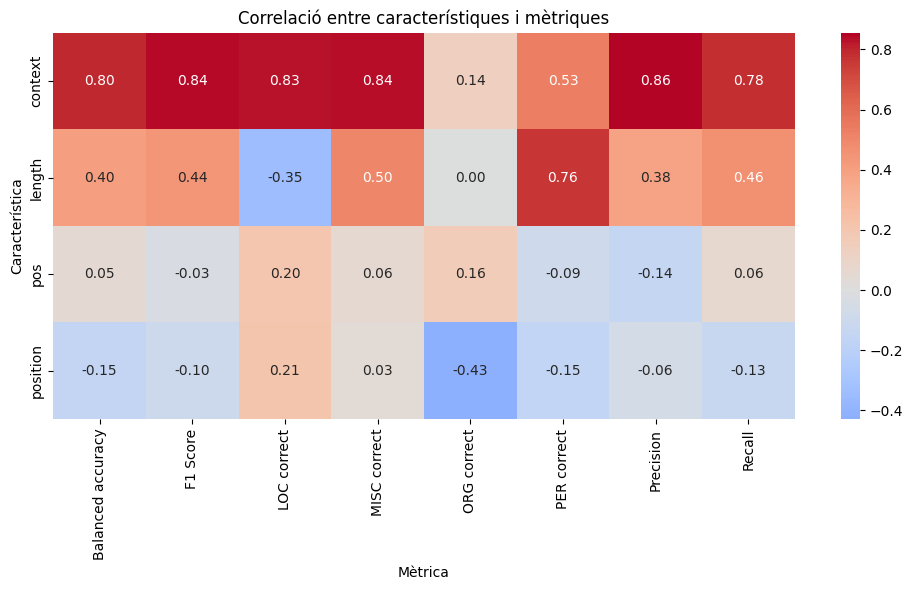

In [26]:
correlacions_nl = analisi_correlacio_caracteristiques(optimized_results_nl)

### Interpretació de les correlacions (Neerlandès)

L’anàlisi de les correlacions entre característiques i mètriques per al model de NER en neerlandès mostra patrons clars que ens ajuden a entendre la contribució de cada característica:

1. **Context**: És, amb diferència, la característica més rellevant. Mostra una forta correlació amb totes les mètriques generals (Balanced accuracy: **0.80**, F1 Score: **0.84**, Precision: **0.86**, Recall: **0.78**) i també amb les entitats (LOC, MISC, PER). És una característica central per a la detecció i classificació d’entitats.

2. **Length**: Té una correlació positiva amb la majoria de mètriques, destacant especialment en **PER correct** (**0.76**) i MISC (**0.50**). És útil per reconèixer entitats més llargues o estructurades, però té una correlació negativa amb LOC (**-0.35**), la qual cosa suggereix certa limitació en entitats curtes.

3. **POS**: Mostra correlacions molt febles amb totes les mètriques, indicant una **aportació marginal** al rendiment del model. Pot ajudar lleugerament en la diferenciació entre LOC i ORG, però no és essencial.

4. **Position**: En general, té correlacions negatives, especialment amb **ORG correct** (**-0.43**) i balanced accuracy (**-0.15**). Aquesta característica sembla **introduir soroll**, probablement per la seva interacció amb altres variables ja informatives com context i length.

Aquestes correlacions reforcen la importància de seleccionar acuradament les característiques. En el cas del neerlandès:

- Per maximitzar la **precisió i recall**, la característica **context** és imprescindible.
- La **longitud** complementa bé context, especialment per reconèixer noms propis llargs (PER).
- Les característiques **POS** i **position** poden ser descartades per simplificar el model sense gaire pèrdua de rendiment.

In [30]:
# Troba la millor configuració segons la mètrica 'Balanced accuracy'
best_row = optimized_results_nl.sort_values(by="F1 Score", ascending=False).iloc[1]
print("Millor configuració trobada:")
print(best_row["Configuració"])
print("\nDetalls de la configuració:")

# Extreu els flags de la configuració òptima
best_config_ned = {
    "word_form": True,
    "morphology": True,
    "gazetteers": True,
    "prefix_suffix": True,
    "pos": bool(best_row["te_pos"]),
    "context": bool(best_row["te_context"]),
    "length": bool(best_row["te_length"]),
    "position": bool(best_row["te_position"])
}
display(best_config_ned)

Millor configuració trobada:
Base + context + length

Detalls de la configuració:


{'word_form': True,
 'morphology': True,
 'gazetteers': True,
 'prefix_suffix': True,
 'pos': False,
 'context': True,
 'length': True,
 'position': False}

### Millor configuració trobada per al neerlandès

L'estudi sistemàtic de característiques mostra que la millor configuració per al neerlandès coincideix amb la de l'espanyol: maximitza la "Balanced accuracy" i el "F1-score" activant `word_form`, `context`, `gazetteers`, `lenght`, `prefix_suffix` i `morphology`,  i desactivant `pos` i `position`.

Aquesta diferència indica que, tot i compartir algunes característiques rellevants (com la forma de la paraula i el context), el model per al neerlandès es beneficia especialment de la informació de longitud i del context, mentre que les etiquetes gramaticals i la posició no són tan útils com en l'espanyol. Això reforça la necessitat d'adaptar la selecció de característiques a cada idioma per maximitzar el rendiment del model NER.

## Experimentació amb les codificacions

Per optimitzar el reconeixement d'entitats anomenades, no només és important seleccionar les característiques adequades, sinó també escollir un esquema de codificació d'etiquetes que permeti al model aprendre eficaçment les fronteres entre entitats. En aquesta secció, comparem diferents esquemes de codificació per avaluar la seva influència en el rendiment del model.

1. IO (Inside-Outside)  
2. BIO (Begin-Inside-Outside)  
3. BIOE (Begin-Inside-Outside-End)  
4. BIOS (Begin-Inside-Outside-Single)  
5. BIOES (Begin-Inside-Outside-End-Single)  

Cada esquema defineix de manera diferent com es marquen els límits d’una entitat, especialment en entitats d’un sol token o en la finalització d’entitats multi-token. Això pot afectar la capacitat del model per aprendre patrons precisos de començament i final d’entitat.

Per realitzar una comparació justa, vam implementar funcions específiques que convertien el nostre conjunt de dades original en format BIO als altres esquemes. A continuació es mostren les funcions utilitzades:

In [31]:
def train_to_IO(train):
    train_io = []
    for sent in train:
        sent_io = []
        for word, pos, tag in sent:
            new_tag = re.sub(r'\bB-', 'I-', tag)
            sent_io.append((word, pos, new_tag))
        train_io.append(sent_io)
    return train_io

esp_train_IO = train_to_IO(esp_train)
ned_train_IO = train_to_IO(ned_train)

# Imprimeix un exemple de la conversió a IO
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format IO:")
print(esp_train_IO[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format IO:
[('Melbourne', 'NP', 'I-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'I-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'I-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [32]:
def train_to_BIOE(train):
    train_bioe = []
    for sent in train:
        sent_bioe = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioe.append((word, pos, tag))
        train_bioe.append(sent_bioe)
    return train_bioe

esp_train_BIOE = train_to_BIOE(esp_train)  # Original BIO data
ned_train_BIOE = train_to_BIOE(ned_train)  # Original BIO data

# Imprimeix un exemple de la conversió a BIOE
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOE:")
print(esp_train_BIOE[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOE:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [33]:
def train_to_BIOS(train):
    train_bios = []
    for sent in train:
        sent_bios = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('B-') and (i == len(sent) - 1 or sent[i + 1][2] == 'O'):
                tag = re.sub(r'\bB-', 'S-', tag)
            sent_bios.append((word, pos, tag))
        train_bios.append(sent_bios)
    return train_bios

esp_train_BIOS = train_to_BIOS(esp_train)
ned_train_BIOS = train_to_BIOS(ned_train)


# Imprimir un exemple de la conversió a BIOS
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOS:")
print(esp_train_BIOS[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOS:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [36]:
def train_to_BIOES(train):
    train_bioes = []
    for sent in train:
        sent_bioes = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('B-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bB-', 'S-', tag)
            elif tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioes.append((word, pos, tag))
        train_bioes.append(sent_bioes)
    return train_bioes

esp_train_BIOES = train_to_BIOES(esp_train)
ned_train_BIOES = train_to_BIOES(ned_train)

# Imprimir un exemple de la conversió a BIOES
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOES:")
print(esp_train_BIOES[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOES:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


### Comparativa de les codificacions

Per comparar l'impacte dels diferents esquemes de codificació d'etiquetes (BIO, IO, BIOE, BIOS, BIOES) en el rendiment del model NER, hem entrenat i avaluat models CRF per a cada esquema tant en espanyol com en neerlandès.

**Procediment:**
- Per cada esquema, es converteixen tant el conjunt d'entrenament com el de validació al format corresponent.
- Es manté la mateixa configuració òptima de característiques (`best_config`) per garantir una comparació justa.
- Es calcula el rendiment amb les principals mètriques



In [38]:
import pandas as pd
# Definir els diferents esquemes de codificació i els seus datasets
train_sets_ca = [esp_train, esp_train_IO, esp_train_BIOE, esp_train_BIOS, esp_train_BIOES]
train_sets_nl = [ned_train, ned_train_IO, ned_train_BIOE, ned_train_BIOS, ned_train_BIOES]

# Utilitzar un subconjunt petit per accelerar la comparació
petit_train_sets_ca = [ts[:2500] for ts in train_sets_ca]
petit_train_sets_nl = [ts[:2500] for ts in train_sets_nl]

# Funció auxiliar per convertir el dev segons l'esquema
def convertir_dev(dev, idx):
    if idx == 1:
        return train_to_IO(list(dev))
    elif idx == 2:
        return train_to_BIOE(list(dev))
    elif idx == 3:
        return train_to_BIOS(list(dev))
    elif idx == 4:
        return train_to_BIOES(list(dev))
    else:
        return list(dev)

# Avaluar el model per a cada esquema de codificació en català/castellà
resultats_ca = []
processor_ca = NERDataProcessor("spanish")
dev_ca = list(esp_dev)

for idx, train_set in enumerate(petit_train_sets_ca):
    X_train = processor_ca.convert_to_features(train_set)
    y_train = processor_ca.get_labels(train_set)
    dev_ca_scheme = convertir_dev(esp_dev, idx)
    X_dev = processor_ca.convert_to_features(dev_ca_scheme)
    y_dev = processor_ca.get_labels(dev_ca_scheme)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)
    eval_result = evaluate_model(y_dev, y_pred)
    resultats_ca.append(eval_result)

df_resultats_ca = pd.DataFrame(resultats_ca, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
df_resultats_ca = df_resultats_ca.sort_values(by="Balanced accuracy", ascending=False)
display(df_resultats_ca)

# Avaluar el model per a cada esquema de codificació en neerlandès
resultats_nl = []
processor_nl = NERDataProcessor("dutch")
dev_nl = list(ned_dev)

for idx, train_set in enumerate(petit_train_sets_nl):
    X_train = processor_nl.convert_to_features(train_set)
    y_train = processor_nl.get_labels(train_set)
    dev_nl_scheme = convertir_dev(ned_dev, idx)
    X_dev = processor_nl.convert_to_features(dev_nl_scheme)
    y_dev = processor_nl.get_labels(dev_nl_scheme)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)
    eval_result = evaluate_model(y_dev, y_pred)
    resultats_nl.append(eval_result)

df_resultats_nl = pd.DataFrame(resultats_nl, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
df_resultats_nl = df_resultats_nl.sort_values(by="F1 Score", ascending=False)
display(df_resultats_nl)

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIOES,0.708661,0.651467,0.658785,0.644311,0.783145,0.353604,0.623446,0.668309
BIOS,0.705289,0.648001,0.665286,0.631591,0.752312,0.346847,0.606276,0.674056
BIOE,0.705068,0.652686,0.665226,0.640611,0.753340,0.349099,0.618709,0.687192
BIO,0.700688,0.649003,0.670530,0.628816,0.732785,0.322072,0.602724,0.693760
IO,0.682341,0.619684,0.646719,0.594820,0.722508,0.308559,0.543517,0.668309


,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIOES,0.669487,0.605243,0.615354,0.595458,0.569937,0.524590,0.443149,0.835949
BIOS,0.676209,0.599015,0.613646,0.585065,0.567850,0.516393,0.438776,0.811698
BIOE,0.665872,0.596325,0.612667,0.580831,0.546973,0.478142,0.463557,0.825963
BIO,0.671331,0.595626,0.615954,0.576597,0.546973,0.498634,0.462099,0.790300
IO,0.672890,0.583417,0.612972,0.556582,0.582463,0.424863,0.472303,0.758916


Després de provar les diferents codificacions d’etiquetes en el model tant per a l’espanyol com per al neerlandès, observem que les diferències de rendiment entre esquemes (BIO, IO, BIOE, BIOS, BIOES) són pràcticament insignificants. Tot i que en ambdós idiomes l'ordre segons l'F1 Score ha sigut el mateix.

Així doncs, el que sembla ser el millor encoding per a la tasca a resoldre pel model és el BIOES, així que serà el que utilitzarem per a entrenar futurs models.

## Comparativa final entre idiomes

Per a cada llengua (espanyol i neerlandès), hem entrenat un model CRF amb la **configuració òptima** obtinguda prèviament a partir de l’anàlisi de correlacions i l'avaluació empírica.

Utilitzem la funció `train_crf_model`, que:

- Carrega les dades corresponents a la llengua (`spanish` o `dutch`)
- Converteix les etiquetes al format **BIOES** per millorar la consistència dels límits d’entitat
- Construeix els conjunts de característiques mitjançant un generador personalitzat (`CRFFeatureGenerator`) basat en la configuració òptima
- Entrena el model amb els conjunts de dades d'entrenament

In [39]:
def train_crf_model(config: Dict, language: str = "spanish", sample_size=None):
    processor = NERDataProcessor(language)
    train, dev, test_set = processor.load_data()
    train = train_to_BIOES(train)  # Convertir a BIOES
    
    if sample_size:
        train = list(train)[:sample_size]

    X_train = processor.convert_to_features(train)
    y_train = processor.get_labels(train)

    feature_gen = CRFFeatureGenerator(config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)

    return model, processor, dev, test_set

def evaluate_crf_model(model, processor, eval_set, sample_size=None, error=False):
    if sample_size:
        eval_set = list(eval_set)[:sample_size]

    X_eval = processor.convert_to_features(eval_set)
    y_eval = processor.get_labels(eval_set)
    y_pred = model.predict(X_eval)

    results = evaluate_model(y_eval, y_pred, errors=error)
    if error:
        return results[0], results[1]
    return results

model_es, processor_es, dev_es, test_es = train_crf_model(best_config, language="spanish")
model_nl, processor_nl, dev_nl, test_nl = train_crf_model(best_config_ned, language="dutch")

Primer avaluem sobre el conjunt dev:

In [40]:
# Evaluar el modelo en el conjunto de prueba
results_es = evaluate_crf_model(model_es, processor_es, dev_es)
results_nl = evaluate_crf_model(model_nl, processor_nl, dev_nl)

def language_comparison(results_es=None, results_nl=None):
    # Comparar els resultats entre els dos idiomes
    results = {
        "Espanyol": results_es,
        "Neerlandès": results_nl
    }
    df_results = pd.DataFrame(results).T
    return df_results
# Executar la comparació entre idiomes

language_results = language_comparison(results_es, results_nl)
language_results

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Espanyol,0.780564,0.728671,0.734492,0.722942,0.830421,0.439189,0.703967,0.766831
Neerlandès,0.783119,0.741884,0.773829,0.712471,0.764092,0.673497,0.593294,0.834522


### Comparativa entre espanyol i neerlandès en dev

Els resultats mostren que el rendiment global del model CRF és molt similar en ambdós idiomes, amb una *balanced accuracy* pràcticament idèntica (0.78). No obstant això, s'observen diferències rellevants segons el tipus d'entitat:

- **Espanyol**: destaca en la detecció d'entitats de tipus **LOC** (0.83) i **ORG** (0.70), però obté pitjors resultats en **MISC** (0.44).
- **Neerlandès**: sobresurt en la detecció d'entitats **PER** (0.83) i **MISC** (0.67), i mostra una precisió lleugerament superior (0.77 vs 0.73), tot i un *recall* una mica inferior.

Això indica que, tot i que el model generalitza bé en ambdós idiomes, la distribució i la naturalesa de les entitats afecten el rendiment per tipus. El model en neerlandès és més robust per a persones i entitats miscel·lànies, mentre que en espanyol destaca en localitzacions i organitzacions, tot i que significativament inferior en entitats miscel·lànies, cosa que genera un F1-score inferior a efectes globals.

En resum, l'estratègia de selecció de característiques i codificació és transferible entre idiomes, però l'optimització fina per tipus d'entitat pot requerir ajustos específics segons la llengua i el corpus.

## Comparativa final en el conjunt de test

In [41]:
results_test_es, error_es = evaluate_crf_model(model_es, processor_es, test_es, error=True)
results_test_nl, error_nl = evaluate_crf_model(model_nl, processor_nl, test_nl, error=True)
# Comparar els resultats entre els conjunts de test
language_results_test = language_comparison(results_test_es, results_test_nl)
language_results_test

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Espanyol,0.807310,0.776267,0.780689,0.771895,0.751622,0.461765,0.813438,0.866303
Neerlandès,0.807895,0.781576,0.811011,0.754203,0.803364,0.658723,0.671202,0.888686


### Comparativa entre espanyol i neerlandès en test

Els resultats sobre el conjunt de test confirmen que el model CRF optimitzat manté un rendiment molt similar en espanyol i neerlandès, amb *balanced accuracy* i *F1 Score* pràcticament idèntics (0.81 i 0.78 respectivament). Això demostra que el model generalitza bé també en conjunts externs i no només en validació.

- **Neerlandès**: obté millor precisió (0.81 vs 0.78), i destaca especialment en la detecció de **PER** (0.89) i **MISC** (0.66).
- **Espanyol**: sobresurt en **ORG** (0.81) i manté un bon nivell en **PER** (0.87), però mostra resultats inferiors en **MISC**.

Aquesta estabilitat en el rendiment entre conjunts de validació i test reforça la robustesa dels models. Tot i així, les diferències per tipus d'entitat evidencien la importància d'adaptar la selecció de característiques i l'avaluació segons la distribució d'entitats de cada llengua i corpus.


## Anàlisi d'errors

A continuació seleccionarem alguns exemples aleatòris mal classificats pels models per analitzar el motiu d'aquests errors i possibles millores.

In [54]:
import random
import pandas as pd

def show_error_analysis(results_test, test, error):
    random.seed(55)
    # Escull un error aleatori dels errors del test espanyol
    error = random.choice(error)

    idx = error[0]
    entity = error[1]

    # Recupera l'oració original i les etiquetes reals/predites
    sentence_bad = list(test)[idx]
    sentence = [token[0] for token in sentence_bad]
    true_tags = [token[2] for token in sentence_bad]
    pred_tags = results_test.get('y_pred', None)
    if pred_tags is None:
        # Si no està guardat, torna a predir
        X_test = processor_es.convert_to_features(list(test))
        pred_tags = model_es.predict(X_test)
        results_test['y_pred'] = pred_tags

    # Mostra l'oració, etiquetes reals i predites en un DataFrame per a millor visualització

    df_error = pd.DataFrame({
        "Token": sentence,
        "Real tag": true_tags,
        "Pred tag": pred_tags[idx]
    })
    # Mostra l'oració, etiquetes reals i predites en horitzontal (una sola fila)
    display(df_error.T.style.hide(axis="columns"))

show_error_analysis(results_test_es, test_es, error_es)
show_error_analysis(results_test_nl, test_nl, error_nl)

Token,Si,al,final,vence,el,Madrid,me,lo,tomaría,bien,porque,al,fin.,al,cabo,es,mi,hermano,y,le,deseo,lo,mejor,"""",",",indicó,Luis,Helguera,.
Real tag,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-PER,I-PER,O
Pred tag,O,O,O,O,O,S-LOC,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-PER,E-PER,O


Token,Na,een,voorbereidingsperiode,van,twee,jaar,is,acteur-regisseur,Jeroen,Krabbé,gisteren,in,het,kasteel,Het,Nijenhuis,in,het,Nederlandse,Heino,begonnen,met,de,verfilming,van,The,Discovery,of,Heaven,",",naar,de,roman,De,Ontdekking,van,de,Hemel,van,Harry,Mulisch,.
Real tag,O,O,O,O,O,O,O,O,B-PER,I-PER,O,O,O,O,B-LOC,I-LOC,O,O,B-MISC,B-LOC,O,O,O,O,O,B-MISC,I-MISC,I-MISC,I-MISC,O,O,O,O,B-MISC,I-MISC,I-MISC,I-MISC,I-MISC,O,B-PER,I-PER,O
Pred tag,O,O,O,O,O,O,O,O,B-PER,E-PER,O,O,O,O,B-PER,E-PER,O,O,B-PER,E-PER,O,O,O,O,O,B-MISC,E-MISC,O,O,O,O,O,O,B-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,E-MISC,O


#### Anàlisi d'errors en els models NER

L'anàlisi dels errors de classificació revela patrons significatius en ambdós models:

**Model espanyol:** Tendeix a classificar erròniament topònims usats com a organitzacions. L'exemple de "Madrid" és representatiu: el model el classifica com a LOC (localització) quan en context es refereix al club de futbol (ORG). Aquest error evidencia la dificultat del model per resoldre ambigüitats contextuals entre noms de llocs i les organitzacions que porten aquests noms.

**Model neerlandès:** Mostra una tendència a sobreclassificar elements com a PER (persones). Els exemples "Het" (article), "Nederlandse" (adjectiu) i "Heino" reflecteixen aquesta propensió. El model sembla donar massa pes a característiques morfològiques com les majúscules inicials, ignorant pistes gramaticals que indicarien que aquests tokens no són noms de persona.

Aquests errors suggereixen que caldria millorar la comprensió contextual dels models i incorporar regles gramaticals específiques per a cada idioma.

## Conclusions finals

Aquesta pràctica ha permès desenvolupar i analitzar en profunditat sistemes NER basats en CRF, proporcionant diverses lliçons valuoses:

1. **Disseny de característiques**: L'anàlisi d'ablació ha demostrat que els atributs morfològics, gazetteers i prefixos/sufixos són essencials, mentre que posició i longitud poden introduir soroll.

2. **Diferències entre idiomes**: Els models presenten fortaleses diferents segons el tipus d'entitat. El model espanyol destaca en localitzacions i organitzacions, mentre que el neerlandès destaca en persones i entitats miscel·lànies.

3. **Esquemes de codificació**: La comparació entre diferents formats d'etiquetatge (IO, BIO, BIOES) ha mostrat diferències mínimes, amb lleuger avantatge per a BIOES.

4. **Anàlisi d'errors**: Els errors identificats revelen limitacions amb ambigüitats contextuals ("Madrid" com a club vs. ciutat) i propietats morfosintàctiques específiques de cada llengua.

En conclusió, els models CRF (F1-score ~0.78) ofereixen bon rendiment, però els patrons d'error suggereixen que models més avançats basats en deep learning podrien superar les limitacions identificades en capturar millor dependències contextuals.

## Extra: CADEC Corpus

El Consumer Adverse Drug Event Corpus (CADEC) és una base de dades especialitzada en farmacovigilància, que recull experiències d’usuaris amb medicaments (incloent efectes adversos). Com que aquesta base de dades no es pot descarregar a través de nltk, haurem de crear una funció personalitzada per llegir-lo i adaptar-lo per al nostre model NER.

In [55]:
# Ajustament per treballar amb dades específiques de CADEC
def load_cadec_data(filepath):
    """Carrega dades CADEC i extreu tipus d'entitats (ADR, Di, Dr, S, F)"""
    sentences = []
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            raw_text = f.read()
        
        # Dividir en oracions (assumint una oració per línia o separació per línia en blanc)
        raw_sents = [s.strip() for s in raw_text.split('\n\n') if s.strip()]
        
        for sent in raw_sents:
            tokens = []
            for line in sent.split('\n'):
                if line.strip():
                    # Assumint format CoNLL: token pos chunk tag
                    parts = line.split()
                    if len(parts) >= 4:  # Assegurem que tenim prou columnes
                        word = parts[0]
                        tag = parts[3]  # Etiqueta d'entitat (O, B-ADR, I-ADR, etc.)
                        
                        # Eliminar l'identificador, mantenir només el tipus d'entitat
                        if tag != 'O' and '-' in tag:
                            prefix, entity_type = tag.split('-', 1)
                            # Mantenir només el tipus d'entitat (ADR, Di, Dr, S, F), eliminar identificadors
                            if '+' in entity_type:
                                entity_type = entity_type.split('+')[0]
                            tag = f"{prefix}-{entity_type}"
                        
                        tokens.append((word, tag))
            
            if tokens:
                sentences.append(tokens)
    
    except Exception as e:
        print(f"Error en carregar dades CADEC: {e}")
        return []
    
    return sentences

Tal com s’ha comentat, aquest corpus està especialitzat en serveis farmacèutics i medicinals (efectes adversos de medicaments), i per això utilitza un sistema d’etiquetes úniques compostes per prefixos (B-, I-, O) seguits de llargues seqüències numèriques. Aquests números són codis per identificar, per exemple, conceptes mèdics o tipus de drogues.

In [62]:
cadec_train = load_cadec_data('./cadec/train.conll')
cadec_test = load_cadec_data('./cadec/test.conll')

print(f"Train: {len(cadec_train)} oracions")
print(f"Test: {len(cadec_test)} oracions")

print("Exemple d'una oració:")
print(cadec_train[5])

def count_tags_cadec(dataset):
    tag_counts = {}
    for sent in dataset:
        for _,  tag in sent:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts


cadec_tags = count_tags_cadec(cadec_train)
print("\nDistribució de'etiquetas (train):")
for tag, count in list(sorted(cadec_tags.items(), key=lambda x: x[1], reverse=True))[:10]:
    print(f"{tag}: {count}")
print('...')

Train: 5719 oracions
Test: 1878 oracions
Exemple d'una oració:
[('Was', 'O'), ('getting', 'O'), ('some', 'O'), ('muscle', 'O'), ('aches', 'O'), ('.', 'O')]

Distribució de'etiquetas (train):
O: 89701
B-3877011000036101: 830
B-0: 98
B-3384011000036100: 50
I-0: 49
B-3904011000036106: 37
B-77424011000036100: 35
B-3848011000036104: 25
I-77435011000036104: 20
B-77435011000036104: 19
...


Per observar com els features afecten el rendiment del model, l'executarem amb 3 configuracions: una sense utilitzar-ne cap, una altra que utilitza els features bàsics, i la última configuració que les utilitza totes.

In [63]:
base_config = {
        "word_form": False,
        "pos": False,
        "morphology": False,
        "prefix_suffix": False,
        "length": False,
        "position": False,
        "context": False,
        "gazetteers": False
    }

medium_config = {
        "word_form": True,
        "pos": True,       
        "morphology": True,
        "prefix_suffix": True,
        "length": False,
        "position": False,
        "context": False,
        "gazetteers": True,  
    }

best_config = {
        "word_form": True,
        "pos": True,
        "morphology": True,
        "prefix_suffix": True,
        "length": True,
        "position": True,
        "context": True,
        "gazetteers": True
    }

configs = {"Bàsic": base_config, 
           "Mitjà": medium_config, 
           "Complet": best_config}

Els resultats mostren que, amb conjunts d’entrenament petits, els tres models (bàsic, intermedi i avançat) ofereixen un rendiment similar (*F1-score* proper). No obstant, en escalar a conjunts d’entrenament més grans, s’observa que:

1. El model avançat (amb més features) és lleugerament superior, però a un cost computacional significativament més alt.

2. El model intermedi aconsegueix gairebé la mateixa precisió que l’avançat, però amb un temps d’entrenament i inferència més eficient.

Donada la lleugera diferència entre el model intermedi i l’avançat en escenaris reals (i la necessitat d’equilibri entre precisió i eficiència), hem optat per:

1. Utilitzar el model intermedi (features intermitjos) per a l’entrenament amb el conjunt de dades complet.

2. Descarta el model bàsic (massa simplista) i l’avançat (poc eficient per a la millora marginal).

In [66]:
def train_evaluate_cadec(sample_size=None, feature_config=base_config):
    """
    Entrena i avalua un model CRF en el corpus CADEC.
    Args:
        sample_size: Nombre de frases a utilitzar (None per utilitzar totes)
    Returns:
        Diccionari amb mètriques d'avaluació
    """
    # Prepara dades de train i test
    def prepare_data(data, size):
        data = data[:size] if size else data
        X = [[(word, "NN") for word, tag in sent] for sent in data]
        y = [[tag for _, tag in sent] for sent in data]
        return X, y

    cadec_X_train, cadec_y_train = prepare_data(cadec_train, sample_size)
    cadec_X_test, cadec_y_test = prepare_data(cadec_test, sample_size // 5 if sample_size else None)

    # Entrena model
    feature_gen = CRFFeatureGenerator(feature_config)
    model = CRFModel(feature_gen)
    start_time = time()
    model.train(cadec_X_train, cadec_y_train, model_file='cadec_model.crf')
    print(f"Entrenament completat en {time() - start_time:.2f} segons")

    # Predicció
    start_time = time()
    y_pred = model.predict(cadec_X_test)

    # Avaluació
    def evaluate_cadec(y_true, y_pred):
        correct = sum(
            true_tag != 'O' and true_tag == pred_tag
            for true_sent, pred_sent in zip(y_true, y_pred)
            for true_tag, pred_tag in zip(true_sent, pred_sent)
        )
        total_true = sum(tag != 'O' for sent in y_true for tag in sent)
        total_pred = sum(tag != 'O' for sent in y_pred for tag in sent)
        precision = correct / total_pred if total_pred else 0
        recall = correct / total_true if total_true else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        return {
            'Precisió': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Total entitats reals': total_true,
            'Total entitats predites': total_pred,
            'Predites correctament': correct
        }

    print(feature_config)
    return evaluate_cadec(cadec_y_test, y_pred)


for config in configs:
    display(config)
    cadec_results = train_evaluate_cadec(2500, configs[config])
    display(pd.DataFrame([cadec_results]))

'Bàsic'

Entrenament completat en 19.34 segons
{'word_form': False, 'pos': False, 'morphology': False, 'prefix_suffix': False, 'length': False, 'position': False, 'context': False, 'gazetteers': False}


,Precisió,Recall,F1 Score,Total entitats reals,Total entitats predites,Predites correctament
0,0,0.0,0,136,0,0


'Mitjà'

Entrenament completat en 37.29 segons
{'word_form': True, 'pos': True, 'morphology': True, 'prefix_suffix': True, 'length': False, 'position': False, 'context': False, 'gazetteers': True}


,Precisió,Recall,F1 Score,Total entitats reals,Total entitats predites,Predites correctament
0,0.955882,0.477941,0.637255,136,68,65


'Complet'

Entrenament completat en 46.89 segons
{'word_form': True, 'pos': True, 'morphology': True, 'prefix_suffix': True, 'length': True, 'position': True, 'context': True, 'gazetteers': True}


,Precisió,Recall,F1 Score,Total entitats reals,Total entitats predites,Predites correctament
0,0.944444,0.5,0.653846,136,72,68


### Anàlisi dels resultats del corpus CADEC

1. **Necessitat de característiques**: El model sense característiques és completament inútil, confirmant la importància dels atributs.

2. **Millor equilibri**: La configuració mitjana ofereix el millor balanç entre rendiment i eficiència, captant la majoria dels beneficis amb menor cost computacional.

3. **Rendiment marginal**: L'addició de totes les característiques addicionals (longitud, posició i context) només aporta una millora mínima (3 entitats més) a costa d'un 25% més de temps.

4. **Recomanació**: Per aplicacions pràctiques en el domini mèdic, la configuració mitjana representa l'opció més eficient, oferint excel·lent precisió amb un cost computacional raonable.

### Execució final Corpus CADEC

In [67]:
cadec_results = train_evaluate_cadec(feature_config = configs["Mitjà"])
display(pd.DataFrame([cadec_results]))

Entrenament completat en 330.42 segons
{'word_form': True, 'pos': True, 'morphology': True, 'prefix_suffix': True, 'length': False, 'position': False, 'context': False, 'gazetteers': True}


,Precisió,Recall,F1 Score,Total entitats reals,Total entitats predites,Predites correctament
0,0.945455,0.644628,0.766585,484,330,312


### Conclusions Exercici Extra

Aquest exercici opcional ens ha permès extreure dues lliçons:

1. Impacte dels tags especials en el rendiment del model

Els tags amb codis numèrics únics (com els del corpus CADEC) presenten un repte significatiu degut a la seva baixa freqüència d'aparició.
Aquesta escassetat de dades per a cada tag específic dificulta que el model pugui aprendre patrons consistents i generalitzar correctament.

2. Limitacions en la millora mitjançant features.

Malgrat haver provat diferents combinacions de features (incloent els que van mostrar bons resultats en models previs), el guany en rendiment ha estat marginal.
Això suggereix que:
·Les característiques utilitzades no capturaven suficients rellevàncies contextuals per a aquest corpus específic.
·Potser caldria explorar codificacions més avançades (p. ex., embeddings contextuals com BERT).

### Reflexió final
Els resultats indiquen que, en lloc de dependre únicament de l'enginyeria de features tradicional, podria ser més efectiu:
Reformular l'esquema d'etiquetatge per a equilibrar especificitat i freqüència.
Incorporar mètodes basats en transformers (com ara mBERT o models pre-entrenats en domini mèdic) per a capturar millor les nuances del llenguatge especialitzat.
Aquesta anàlisi obre la porta a futures investigacions sobre com adaptar models NER a dominis tècnics amb etiquetes altament específiques.